# Index Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import scipy.interpolate as interpolate
from scipy.stats import norm, ks_2samp, anderson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis

Our full model is given by,

$$ \left( \begin{array}{c} dT_t \\ dS_{t} \\ \end{array} \right) = \left( \begin{array}{c} \dot{\mu}(t) + \alpha_{1}(\mu(t) - T_{t}) \\ \dot{\sigma}(t) + \alpha_{2}(\sigma(t) - S_{t}) \\ \end{array} \right) dt + \left( \begin{array}{c} S_{t}\sqrt{2\alpha_{1}} & 0 \\ 0 & \chi \\ \end{array} \right) \left( \begin{array}{c} dW^{(1)}_{t} \\ dW^{(2)}_{t} \\ \end{array} \right)$$

Where by, in our model for region $10$ of the UK climate data we find
 
- $\mu(t) = 7.23122408 + 5.92407918\cdot10^{-05}~(t - 3649) - 5.4 \sin(\frac{2\pi}{365.25}t + 1.1557)$
- $\dot{\mu}(t) = 5.92407918\cdot10^{-05}~t - 5.4 \cdot \frac{2\pi}{365.25} \cos(\frac{2\pi}{365.25}t + 1.1557)$
- $\alpha_{1} = 1 - 0.7798 = 0.2202$
- $\sigma(t) = 2.801 - 2.28205148\cdot 10^{-3} x - 2.981 \cdot 10^{-5} x^{2} + 1.0868\cdot 10^{-7} x^{3},~x = t \mod 366$
- $\dot{\sigma}(t) = - 2.28205148\cdot 10^{-3} - 6.962 \cdot 10^{-5} x + 3.2604\cdot 10^{-7} x^{2},~x = t \mod 366$
- $\alpha_{2} = 1 - 0.7067 = 0.2923 $
- $\chi = 0.2299 \cdot \sqrt{2 \alpha_2}$


## Data Processing

month  day
1      1      2.927041
       2      2.881849
       3      2.593544
       4      2.552560
       5      2.788373
                ...   
12     27     3.399486
       28     3.652368
       29     3.669040
       30     3.366287
       31     3.165318
Name: avg, Length: 366, dtype: float64


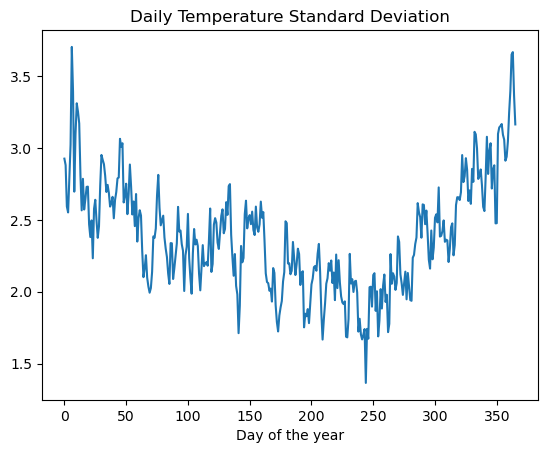

In [2]:
max_daily_dataset = nc.Dataset('../../datasets/tasmax_hadukgrid_uk_region_day_19600101-20211231.nc')
min_daily_dataset = nc.Dataset('../../datasets/tasmin_hadukgrid_uk_region_day_19600101-20211231.nc')
region = 10

def convert_hours_to_datetime(hours):
    base_date = datetime(1800, 1, 1, 0, 0, 0)  # Base date for the calculation
    delta = timedelta(hours=hours)  # Create a timedelta based on the hours
    # Add the timedelta to the base date to get the resulting datetime
    result_datetime = base_date + delta
    return result_datetime.date()

region_daily_min = min_daily_dataset['tasmin'][:, region]
region_daily_max = max_daily_dataset['tasmax'][:, region]
data_dict = {'min': region_daily_min, 'max': region_daily_max, 'time': min_daily_dataset['time'][:]}
df = pd.DataFrame(data=data_dict)
df['date'] = df['time'].apply(convert_hours_to_datetime)
df['avg'] = (df['min'] + df['max'])/2
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract day and month from the 'date' column
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

# Group by day and month, and compute variance for each day
std_by_day = df.groupby(['month', 'day'])['avg'].std()
print(std_by_day)

plt.plot(std_by_day.values)
plt.title("Daily Temperature Standard Deviation")
plt.xlabel("Day of the year")
plt.show()

# Volatility Model

Now we load in our volatility model

In [3]:
x = np.array(np.arange(len(std_by_day.values.flatten())))
y = np.array(std_by_day.values.flatten())

def polynomial_regression_fit(degree, x, y):
    x= x[:,np.newaxis]
    y= y[:,np.newaxis]
    poly_feats = PolynomialFeatures(degree=degree)
    transform = poly_feats.fit_transform(x)
    model = sm.OLS(y, transform).fit()
    predictions = model.predict(transform)
    return model, predictions

def polynomial_regression(degree, x, y):
    _model, predictions = polynomial_regression_fit(degree, x, y)
    return predictions

[ 2.80131071e+00 -2.28205148e-03 -2.98096364e-05  1.08681681e-07]


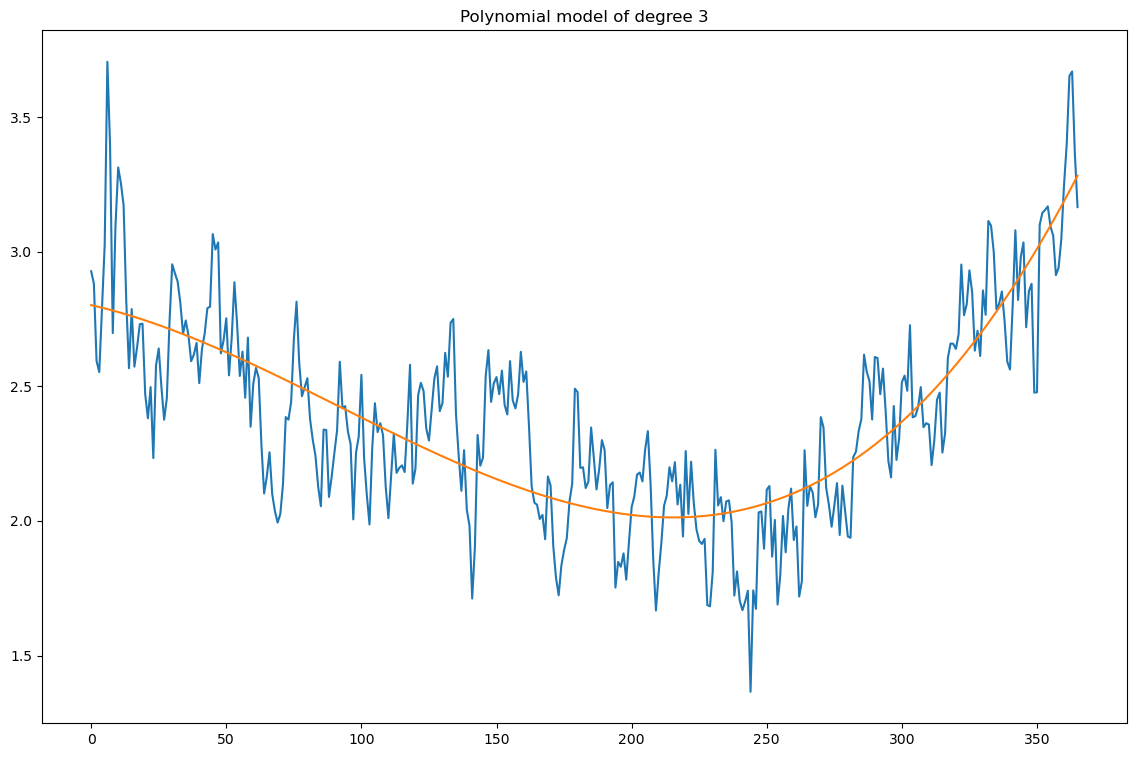

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(14, 9))
# y_model = fourier_series(x, fourier_coeffs, 3)
y_model, y_predictions = polynomial_regression_fit(3, x, y)
axs.plot(y, label="Volatilities")
axs.plot(y_predictions, label="Model")
axs.set_title(f"Polynomial model of degree {3}")
print(y_model.params)

In [5]:
def sigma_derivative(params, t):
    powers = np.arange(1, len(params))  # 1 to len(params)-1
    return np.dot(np.power.outer(t % 366, powers-1), powers * params[1:])

def sigma(params, t):
    powers = np.arange(len(params))
    return np.dot(np.power.outer(t % 366, powers), params)

In [6]:
vol_residuals = y - y_predictions
model_fit = sm.tsa.AutoReg(vol_residuals, lags=1, old_names=True,trend='n').fit()
alpha_2 = 1.0 - model_fit.params[0]
chi = np.std(vol_residuals) * np.sqrt(2 * alpha_2)
print(alpha_2)

0.2933457251325041


/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


## Modified OU process for volatility



$$ dS_{t} = \left( \dot{\sigma}(t) + \alpha_{2}(\sigma(t) - S_{t}) \right) dt + \chi dW_{t} $$

I will simulate paths of this process using an Euler-Maryuama discretisation, the Euler-Maruyama method has strong order of convergence of \frac{1}{2}, however as the diffusion term is not a function of the process $S_{t}$ this is of order $1$ and identical to the Milstein scheme. 

Std: 0.24884137821390198, empirical residual volatility = 0.22994382706706223


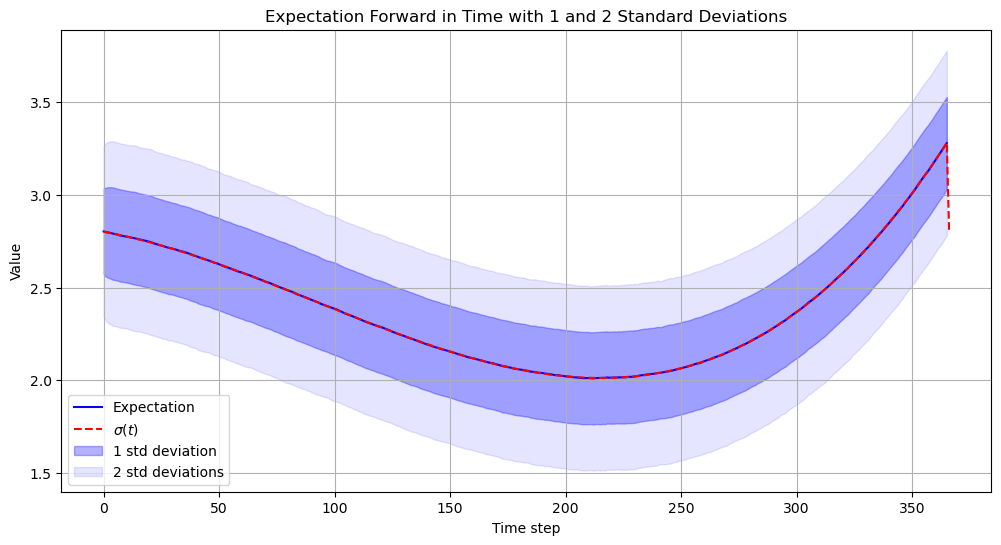

In [12]:
N = 50_000

steps = 366

samples = np.zeros((N, steps))
samples[:, 0] = sigma(y_model.params, 0) + np.random.normal(size=N) * np.std(vol_residuals) 

for t in range(steps-1):
    samples[:, t+1] = samples[:, t] + sigma_derivative(y_model.params, t) + alpha_2 * (sigma(y_model.params, t) - samples[:, t]) + chi * np.random.normal(size=N)

means = np.mean(samples, axis=0)
std_devs = np.std(samples, axis=0)
print(f"Std: {np.mean(std_devs[1:])}, empirical residual volatility = {np.std(vol_residuals)}")

plt.figure(figsize=(12, 6))
plt.plot(means, color='blue', label='Expectation')
plt.plot(np.linspace(0, 366, 366), sigma(y_model.params, np.linspace(0, 366, 366)), label=f"$\sigma(t)$", linestyle='--', c='r')
plt.fill_between(range(366), means - std_devs, means + std_devs, color='blue', alpha=0.3, label='1 std deviation')
plt.fill_between(range(366), means - 2*std_devs, means + 2*std_devs, color='blue', alpha=0.1, label='2 std deviations')
plt.plot()
plt.title('Expectation Forward in Time with 1 and 2 Standard Deviations')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Temperature Simulation



Theta_best: [7.23122408e+00 5.92407918e-05]


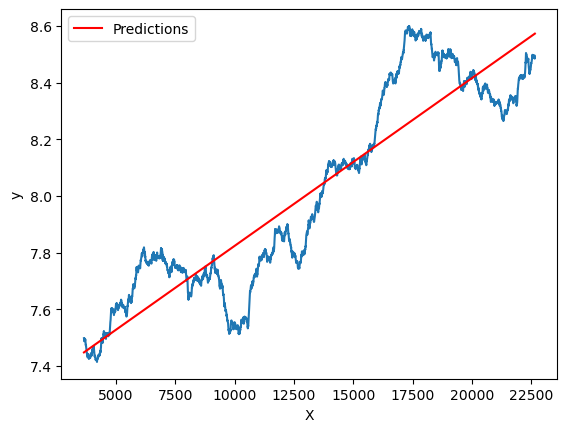

In [116]:
avg_temps = np.copy(df['avg'].rolling(window = 365*10).mean())
X = np.arange(len(avg_temps))
X = X[~np.isnan(avg_temps)]
avg_temps = avg_temps[~np.isnan(avg_temps)]
X_b = np.c_[np.ones((X.shape[0], 1)), X]
# Calculate coefficients using the normal equation
theta_best = np.linalg.inv(X_b.T@(X_b))@(X_b.T)@(avg_temps)
print(f"Theta_best: {theta_best}")
# Prediction
X_new = np.array([[np.min(X)], [np.max(X)]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

# Plotting
plt.plot(X, avg_temps)
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [117]:
def mu(t):
    return 7.23122408 + 5.92407e-5 * (t - 3649) - 5.4 * np.sin((2 * np.pi / 365.25)*t + 1.1557)

def mu_derivative(t):
    return 5.92407e-5 - 5.4 * (2 * np.pi / 365.25) * np.cos((2 * np.pi / 365.25)*t + 1.1557)

alpha_1 = 1 - 0.7067 

Text(0.5, 1.0, 'Trend')

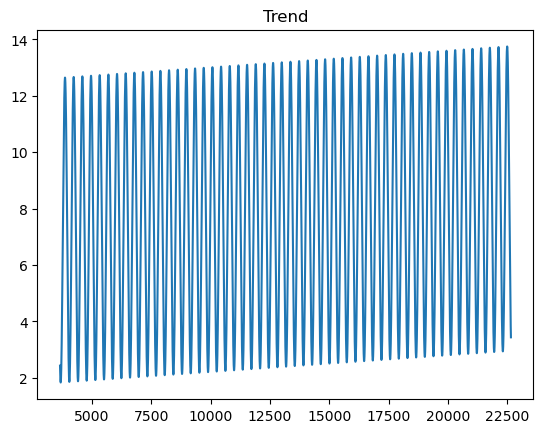

In [123]:
plt.plot(X, mu(X))
plt.title("Trend")

In [118]:
N = 50_000

steps = 366 * 5

std_samples = np.zeros((N, steps))
std_samples[:, 0] = sigma(y_model.params, 0) + np.random.normal(size=N) * np.std(vol_residuals) 

temp_samples = np.zeros((N, steps))
temp_samples[:, 0] = mu(0)

for t in range(steps-1):
    std_samples[:, t+1] = std_samples[:, t] + sigma_derivative(y_model.params, t) + alpha_2 * (sigma(y_model.params, t) - std_samples[:, t]) + chi * np.random.normal(size=N)
    temp_samples[:, t+1] = temp_samples[:, t] + mu_derivative(t) + alpha_1 * (mu(t) - temp_samples[:, t]) + (np.sqrt(2 * alpha_1)) * std_samples[:, t+1] * np.random.normal(size=N) 

means = np.mean(temp_samples, axis=0)
std_devs = np.std(temp_samples, axis=0)

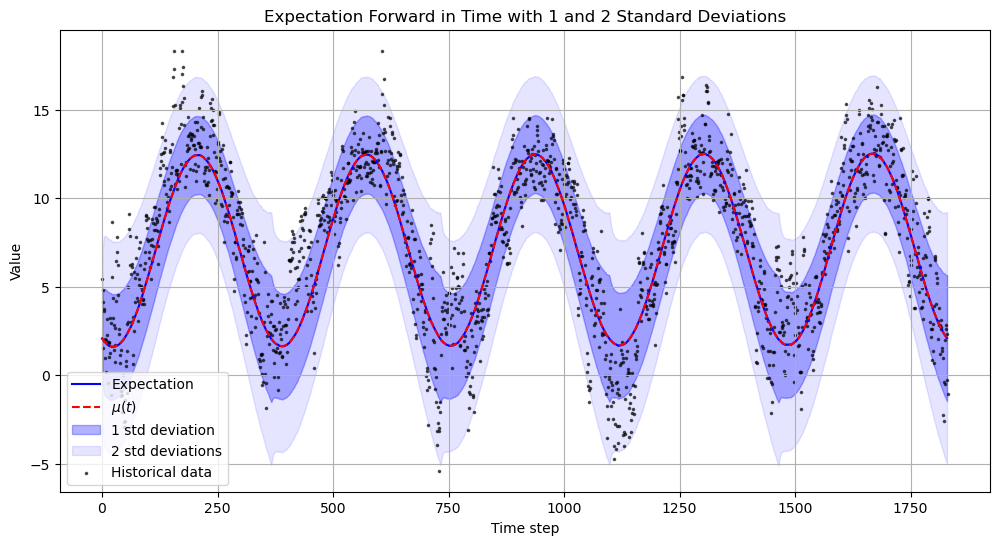

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(means, color='blue', label='Expectation')
plt.plot(np.linspace(0, steps, steps), mu(np.linspace(0, steps, steps)), label=f"$\mu(t)$", linestyle='--', c='r')
plt.fill_between(range(steps), means - std_devs, means + std_devs, color='blue', alpha=0.3, label='1 std deviation')
plt.fill_between(range(steps), means - 2*std_devs, means + 2*std_devs, color='blue', alpha=0.1, label='2 std deviations')
plt.scatter(np.linspace(0, steps, steps), df['avg'][:steps], label="Historical data", c='k', alpha=0.6, marker='.', s=10)
plt.title('Expectation Forward in Time with 1 and 2 Standard Deviations')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

We can also plot the standard deviation of our simulated temperature samples against the process $\sigma(t)$.



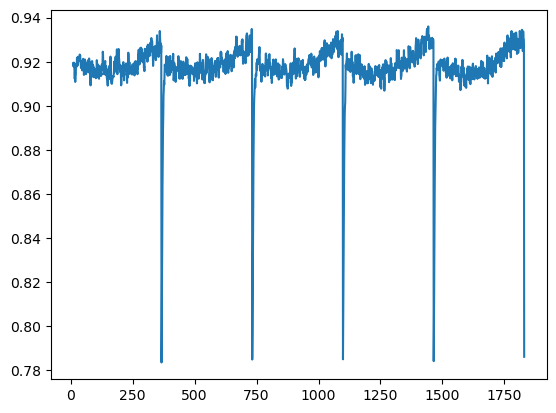

In [120]:
plt.plot(np.linspace(10, steps, steps-10), sigma(y_model.params, np.linspace(0, steps, steps))[10:]/std_devs[10:])
#plt.plot(np.linspace(0, steps, steps), std_devs)